In [24]:
import sys, os
sys.path = ['./scikit-learn/build/lib.linux-x86_64-3.6/'] + sys.path
import sklearn
from sklearn import model_selection, feature_selection
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from log_regression import test, DPLogisticRegression
from ChoiceMaker import DTChoice
import graphviz
import copy
%matplotlib inline

In [25]:
import pickle
"""Method for loading or running a function (if it doesn't exist) located in the metadata folder"""
def load_or_run(name, f):
    name = 'log_regression_metadata/' + name
    try:
        r = pickle.load(open(name, 'rb'))
    except:
        r = f()
        pickle.dump(r, open(name, 'wb'))
    return r

### Data Generation Methods

In [26]:
def reshape_dset(db, ncol, nrow, y_ratio, seed=12345, prng=None):
    """Rescales an input database to the desired parameters.
    Parameters
    ----------
    db: Input array. We assume last col is the output col.
        The output col must be binary.
        
    ncol: Desired number of columns in output.
    
    nrow: Desired number of rows.
    
    y_ratio: Desired percentage of class 2 in the output
    
    seed: seed value to use. Default: 12345
    
    prng: random number generator. One of seed or prng must not be None. 
    """
    if(prng == None):
        prng = np.random.RandomState(seed)
    ys = db[db.columns[-1]]
    v1, v2 = ys.unique()[:2]
    Z1 = db[ys == v1]
    s1 = int(y_ratio*nrow)
    Z2 = db[ys == v2]
    s2 = nrow - s1
    def reshape(Z, nrow):
        db = pd.DataFrame()
        while db.shape[0] + Z.shape[0] < nrow:
            db = pd.concat((db, Z), ignore_index=True)
        return pd.concat((db, Z.sample(nrow - db.shape[0])), ignore_index=True)
    db = pd.concat((reshape(Z1, s1), reshape(Z2, s2)), ignore_index=True)
    db_x = db[db.columns[:-1]]
    ys = db[db.columns[-1]]
    db = pd.DataFrame()
    while db.shape[1] + db_x.shape[1] < ncol:
        db = pd.concat((db, db_x), axis=1, ignore_index=True)
    rand_cols = np.random.choice(db_x.columns, ncol-db.shape[1], replace=False)
    return pd.concat((db, db_x[rand_cols], ys), axis=1, ignore_index=True)

In [27]:
#train_set
#def gen_binary_data(domain, nrow, seed):
ncol = 7
nrow = 1000
seed=12345
y_ratio=0.4
def gen_data(low, high, ncol, nrow, y_ratio, seed=12345, prng=None):
    """Generates an array containing a binary output and inputs drawn 
    from Gaussians. The output is the last column of the array
    and the inputs are the other columns. The inputs are conditionally
    independent of each other given the output. Thus, input at column i
    for output value j are drawn from a normal with mean mu_ij and 
    sigma_ij. Furthermore, we force sigma_ij = sigma_i with no dependence
    on j because this assumption allows us to derive logistic regression
    as the best fitting algorithm. We draw sigma_i and mu_ij randomly.
    We ensure sigma_i is at most one-quarter of high-low to ensure the
    Gaussian will mostly fit in the [low, high] interval.
    
    Parameters
    ----------

    low: lower bound on an input value
    
    high: upper bound on an input value
    
    ncol: number of inputs of the dataset
    
    nrow: number of rows in the dataset
    
    y_ratio: fraction of rows that take value 0 on the output column
    
    seed: seed value to use. Default: 12345
    
    prng: random number generator. One of seed or prng must not be None. 
    """
    if(prng == None):
        prng = np.random.RandomState(seed)
    sigmas = prng.uniform(0, (high-low)/6, ncol)
    s1 = int(y_ratio*nrow)
    s2 = nrow-s1
    def gen_col(sigma, sz):
        mu = prng.uniform(low+3*sigma, high-3*sigma)
        ans = prng.normal(mu, sigma, sz)
        c = (ans < low).sum()
        while(c > 0):
            ans[ans < low] = prng.normal(mu, sigma, c)
            c = (ans < low).sum()
        c = (ans > high).sum()
        while(c > 0):
            ans[ans > high] = prng.normal(mu, sigma, c)
            c = (ans > high).sum()
        return ans
    P1 = np.array([gen_col(s, s1) for s in sigmas] + [np.zeros(s1)]).T
    P2 = np.array([gen_col(s, s2) for s in sigmas] + [np.ones(s2)]).T
    A = np.concatenate((P1, P2))
    return A[np.random.permutation(len(A))]

### ChoiceMaker Classes

In [28]:
#TODO: Change this to sklearn.model_selection.KFold
def manual_CV(db, parts, clf):
    """Does cross-validation on the dataframe."""
    kf = model_selection.KFold(parts)
    arr = []
    for train_idx, test_idx in kf.split(db.X):
        X_test = db.X.iloc[test_idx]
        y_test = db.y.iloc[test_idx]
        X_train = db.X.iloc[train_idx]
        y_train = db.y.iloc[train_idx]
        #Have to fix case when only one class exists
        if len(np.unique(y_train)) == 1:
            score = (y_train == y_train.iloc[0]).sum() / len(y_train)
            arr.append(score)
        else:
            clf.fit(X_train, y_train)
            arr.append(clf.score(X_test, y_test))
    return np.array(arr)

In [29]:
#alg_list
class DP:
    def __init__(self, C):
        self.name = str(C)
        self.model = DPLogisticRegression(0.1, C=C, K=1.02, fit_intercept=True)
    def error(self, db):
        A = manual_CV(db, 5, self.model)
        return 1.0-A.mean()
    def run(self, db):
        self.model.set_epsilon(db.epsilon)
        return self.model.fit(db.X, db.y)

In [30]:
class DB:
    def __init__(self, X, y, epsilon=1):
        self.epsilon = epsilon
        self.ncol = X.shape[1]
        self.X = pd.get_dummies(X)
        self.y = y

In [31]:
class DBMetafeatures:
    def __init__(self):
        self.sensitivities = {'nrow': 0, 'ncol': 0, 'eps': 0, 'numy': 1}
    
    def __call__(self, dataset):
        return {'nrow': dataset.X.shape[0], 
                'ncol': dataset.ncol,
                'eps': dataset.epsilon, 
                'numy': dataset.y.sum()}

In [32]:
#Generating Tset methods
def gen_tset_size_range(eps_vals, col_vals, row_vals, ratios, reps, db, prng=None):
    """Generates a database for each member of the cross product of the arguments
    
    Params:
    db: Database to perform surgery on
    """
    for c in col_vals:
        for r in row_vals:
            for e in eps_vals:
                for ratio in ratios:
                    for x in range(0, reps):
                        G = reshape_dset(db, ncol=c, nrow=r, y_ratio=ratio, prng=prng)
                        ncol = adult.shape[1]
                        last_name = G.columns[-1]
                        yield DB(G.drop([last_name], axis=1), G[last_name], e)
            
#G = gen_tset_size_range(4, [0.2, 0.4, 0.6, 0.8, 1.0], np.arange(20, 200, 20))

### Adult Dataset Preprocessing

In [33]:
adult = pd.read_csv('data/adult.data', header=None)
adult = adult.rename(columns = {0: 'age', 1: 'workclass', 2: 'fnlwgt', 3: 'education', 
                                4: 'education_num', 5: 'marital_status', 6: 'occupation',
                                7: 'relationship', 8: 'race', 9: 'sex', 10: 'captial_gain',
                                11: 'captial_loss', 12: 'hours-per-week', 13: 'native_country', 14: 'TARGET'})
adult = adult.drop('education', axis=1)

In [34]:
le = LabelEncoder()
adult['TARGET'] = le.fit_transform(adult['TARGET'])

### Magic Dataset

In [35]:
magic = pd.read_csv('data/magic.csv', header=None)

In [36]:
magic[10] = le.fit_transform(magic[10])

### Credit Default Dataset Preprocessing

In [37]:
default = pd.read_csv('data/application_train.csv')
default['TARGET'] = le.fit_transform(default['TARGET'])

In [38]:
#C = default.corr()
#default = default[abs(C['TARGET']).sort_values().index[-30:]].sample(10000)

In [39]:
#For simplicity, get rid of all columns with missing data
default = default[default.columns[default.notnull().all()]].sample(10000)

In [40]:
#Put target at end
new_cols = list(default.columns)
new_cols[1] = new_cols[-1]
new_cols[-1] = 'TARGET'
default = default[new_cols]

### Lending Dataset Preprocessing

In [41]:
lending = pd.read_csv('data/fam_credit_ss.csv')

In [42]:
#Swap first and last column
L = list(lending.columns)
L[0] = L[-1]
L[-1] = 'credit_card'
lending = lending[L]

In [43]:
#Some columns should be changed to object
lending.select_dtypes(['int64']).apply(pd.Series.nunique)

social_security       4
stud_loan             4
medical_exp           4
income             5963
marital_status        6
auto_insurance      712
children             10
age                  85
gender                2
housing               3
health_status         7
work_hours           93
credit_card           2
dtype: int64

In [44]:
unordered_cols = ['social_security', 'stud_loan', 'medical_exp', 'marital_status', 'housing', 'health_status']
lending[unordered_cols] = lending[unordered_cols].astype('object')

### Data analysis

In [45]:
prng = np.random.RandomState(12345)
eps_vals = [0.1, 0.2, 0.4, 0.8, 1.6, 3.2]
col_vals = np.arange(2, 20, 2)
row_vals = [20, 40, 100, 150, 300, 600, 1000, 2000, 3000]
ratios = [0.15, 0.3, 0.5, 0.7, 0.85]
num_reps = 3
C_list = [0.1, 1, 10]
alg_list = [DP(C=x) for x in C_list]
def split_db(db, prng=None):
    return gen_tset_size_range(eps_vals, col_vals, row_vals, ratios, num_reps, db, prng)

In [22]:
#Database Generation:
#Unfortunately, these have to be lists, not generators
adult_data = load_or_run('adult.p', lambda: list(split_db(adult, prng)))
default_data = load_or_run('default.p', lambda: list(split_db(default, prng)))
lending_data = load_or_run('lending.p', lambda: list(split_db(lending, prng)))
magic_data = load_or_run('magic.p', lambda: list(split_db(magic, prng)))

NameError: name 'load_or_run' is not defined

In [44]:
def get_cm(db):
    return DTChoice(db, DBMetafeatures(), {a.name: a for a in alg_list}, reps=1)
from multiprocessing import Pool
pool = Pool(processes=3)
cms = pool.map(get_cm, [adult_data, default_data, lending_data])
adult_cm = cms[0]
default_cm = cms[1]
lending_cm = cms[2]

In [62]:
#magic_cm = get_cm(magic_data)
#pickle.dump(magic_cm, open('log_regression_metadata/magic_cm.p', 'wb'))

In [46]:
adult_cm = pickle.load(open('log_regression_metadata/adult_cm.p', 'rb'))
default_cm = pickle.load(open('log_regression_metadata/default_cm.p', 'rb'))
lending_cm = pickle.load(open('log_regression_metadata/lending_cm.p', 'rb'))
magic_cm = pickle.load(open('log_regression_metadata/magic_cm.p', 'rb'))
#pickle.dump(adult_cm, open('log_regression_metadata/adult_cm.p', 'wb'))
#pickle.dump(default_cm, open('log_regression_metadata/default_cm.p', 'wb'))
#pickle.dump(lending_cm, open('log_regression_metadata/lending_cm.p', 'wb'))

In [34]:
#Experiment 1: Test the adult data and the lending data's prediction power on default data.
#Trials are cached within lending and adult data
import importlib
importlib.reload(sklearn)
default_test_cm = DTChoice(adult_data + lending_data, DBMetafeatures(), 
                       {a.name: a for a in alg_list}, 1,
                       pd.concat((adult_cm.regrets, lending_cm.regrets), ignore_index=True))
default_test_cm.model = sklearn.tree.DecisionTreeClassifier(min_samples_leaf=10)
default_test_cm.model.fit(default_test_cm.X, default_test_cm.y, default_test_cm.regrets, 0.02)

adult_test_cm = DTChoice(default_data + lending_data, DBMetafeatures(), 
                       {a.name: a for a in alg_list}, 1,
                       pd.concat((default_cm.regrets, lending_cm.regrets), ignore_index=True))
adult_test_cm.model = sklearn.tree.DecisionTreeClassifier(min_samples_leaf=10)
adult_test_cm.model.fit(adult_test_cm.X, adult_test_cm.y, adult_test_cm.regrets, 0.02)

lending_test_cm = DTChoice(adult_data + default_data, DBMetafeatures(), 
                       {a.name: a for a in alg_list}, 1,
                       pd.concat((adult_cm.regrets, default_cm.regrets), ignore_index=True))
lending_test_cm.model = sklearn.tree.DecisionTreeClassifier(min_samples_leaf=10, max_depth=3)
lending_test_cm.model.fit(lending_test_cm.X, lending_test_cm.y, lending_test_cm.regrets, 0.02)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [49]:
adult_cm.metafeatures.sensitivities.values()

dict_values([0, 0, 0, 1])

In [84]:
import copy

In [101]:

trans = []
L = 4
coefs = [-1 for x in range(L)]
while(True):
    def return_func(coefs):
        def f(X):
            new_col = np.array([ np.log(X[X.columns[i]] * coefs[i]) for i in range(len(coefs))]).sum(axis=0)
            return new_col
        idx = 0
        while idx < len(coefs) and coefs[idx] == 0:
            idx += 1
        if idx < len(coefs) and coefs[idx] == -1:
            coefs = np.array(copy.copy(coefs))
            return {'func': f, 'usage': abs(coefs)}
        else:
            return None
    f = return_func(coefs)
    if f is not None:
        trans.append(f)
    idx = len(coefs)-1
    while idx > -1:
        if coefs[idx] == 1:
            coefs[idx] = -1;
        else:
            coefs[idx] += 1
            break
        idx -= 1
    if idx == -1:
        break

In [103]:
list(map(lambda x: x['func'](adult_cm.X), trans))

/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  
/home/jacob/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


[array([ nan,  nan,  nan, ...,  nan,  nan,  nan]),
 array([ nan,  nan,  nan, ...,  nan,  nan,  nan]),
 array([ nan,  nan,  nan, ...,  nan,  nan,  nan]),
 array([ nan,  nan,  nan, ...,  nan,  nan,  nan]),
 array([ nan,  nan,  nan, ...,  nan,  nan,  nan]),
 array([ nan,  nan,  nan, ...,  nan,  nan,  nan]),
 array([ nan,  nan,  nan, ...,  nan,  nan,  nan]),
 array([ nan,  nan,  nan, ...,  nan,  nan,  nan]),
 array([ nan,  nan,  nan, ...,  nan,  nan,  nan]),
 array([ nan,  nan,  nan, ...,  nan,  nan,  nan]),
 array([ nan,  nan,  nan, ...,  nan,  nan,  nan]),
 array([ nan,  nan,  nan, ...,  nan,  nan,  nan]),
 array([ nan,  nan,  nan, ...,  nan,  nan,  nan]),
 array([ nan,  nan,  nan, ...,  nan,  nan,  nan]),
 array([ nan,  nan,  nan, ...,  nan,  nan,  nan]),
 array([ nan,  nan,  nan, ...,  nan,  nan,  nan]),
 array([ nan,  nan,  nan, ...,  nan,  nan,  nan]),
 array([ nan,  nan,  nan, ...,  nan,  nan,  nan]),
 array([ nan,  nan,  nan, ...,  nan,  nan,  nan]),
 array([ nan,  nan,  nan, ..., 

In [35]:
lending_test_cm.model.fit(lending_test_cm.X, lending_test_cm.y, lending_test_cm.regrets, 0.0)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

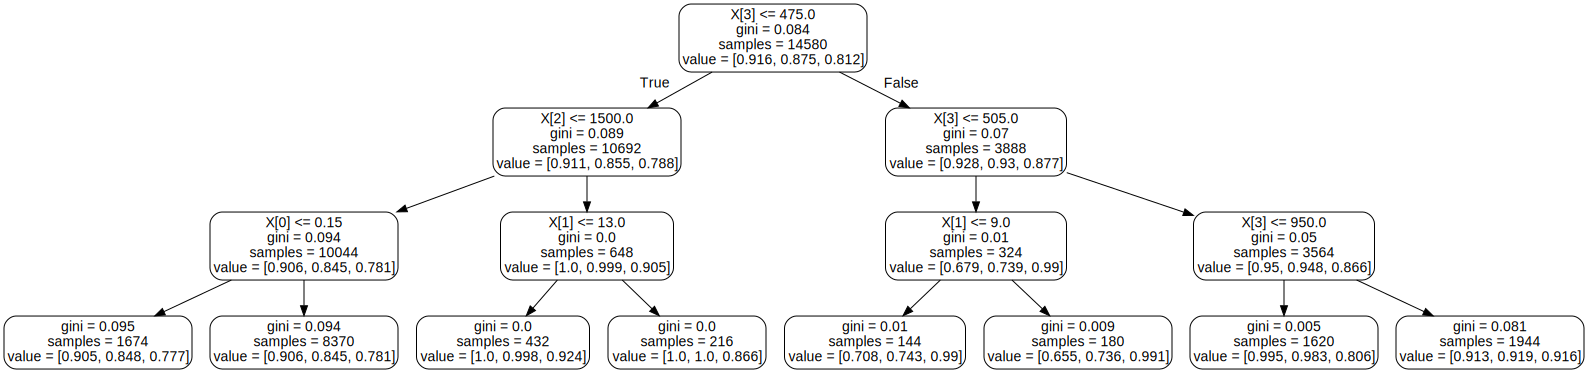

In [36]:
dot_data = sklearn.tree.export_graphviz(lending_test_cm.model, out_file = None, filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph

In [39]:
X = lending_test_cm.X
X.columns
X = np.log(X)

In [40]:
X2 = pd.DataFrame()
coefs = [-1 for x in X.columns]
while(True):
    idx = 0
    while idx < len(coefs) and coefs[idx] == 0:
        idx += 1
    if idx < len(coefs) and coefs[idx] == -1:
        new_col = np.array([X[X.columns[i]] * coefs[i] for i in range(len(coefs))]).sum(axis=0)
        X2[str(coefs)] = new_col
    idx = len(coefs)-1
    while idx > -1:
        if coefs[idx] == 1:
            coefs[idx] = -1;
        else:
            coefs[idx] += 1
            break
        idx -= 1
    if idx == -1:
        break

In [49]:
lending_test_cm.model = sklearn.tree.DecisionTreeClassifier(min_samples_leaf=20)
lending_test_cm.model.fit(X2, lending_test_cm.y, lending_test_cm.regrets, 0.0)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

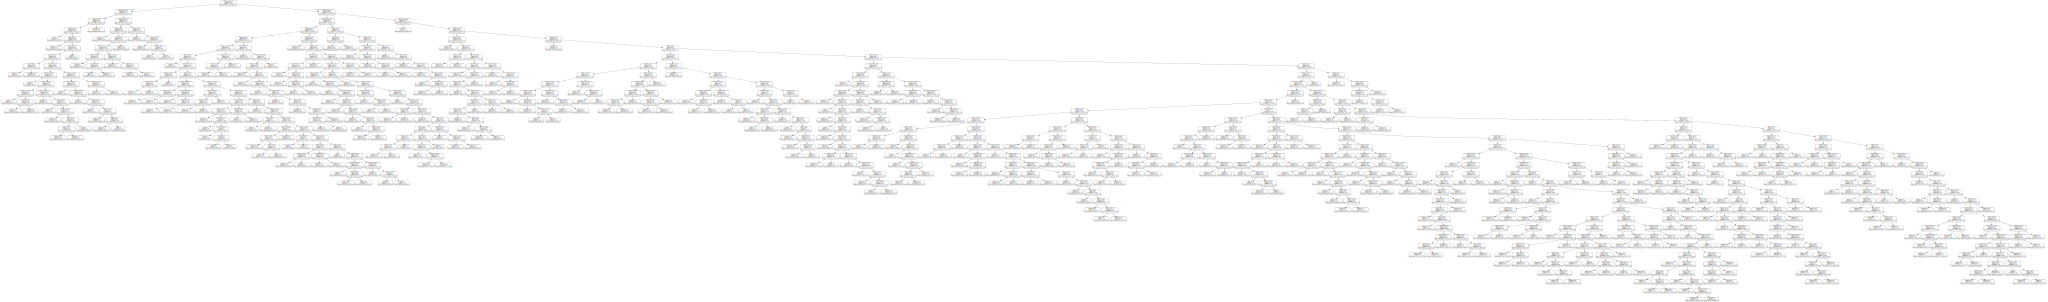

In [50]:
dot_data = sklearn.tree.export_graphviz(lending_test_cm.model, out_file = None, filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph

In [ ]:
#test every third database in adult_data
import copy
adult_data_test = []
for i in range(len(adult_data)):
    if i%3 == 0:
        adult_data_test.append(copy.copy(adult_data[i]))

In [ ]:
adult_errors = [adult_test_cm.get_errors(x, ratio=0.2) for x in adult_data_test]
adult_errors = pd.concat(adult_errors)
adult_errors = adult_errors.reset_index(drop=True)

In [ ]:
adult_errors

### Kamalika's method

In [ ]:
def get_dp_logistic_regression(X_train, y_train, X_test, y_test, 
                             epsilon, ratio, param_list):
    train_eps = epsilon*ratio
    validation_eps = epsilon-train_eps
    #Begin validation
    utils = []
    for C in param_list:
        model = DPLogisticRegression(train_eps, C=C, K=1.02, fit_intercept=True)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        score = (preds == y_test).sum() / y_test.size
        beta = max(1.0/y_test.size, 1.0/y_train.size)
        score += np.random.exponential(1/validation_eps)*beta*2
        utils.append(score)
    return np.array(utils).argmax()

In [ ]:
adult2 = pd.get_dummies(adult)
adult_train = adult2.sample(3000)
cols = adult2.columns[:-1]
y_col = 'TARGET'
X_train = adult_train[cols]
y_train = adult_train[y_col]
adult_test = adult2.sample(1500)
X_test = adult_test[cols]
y_test = adult_test[y_col]

In [ ]:
ratio = 0.8
splits=5
kf = model_selection.KFold(splits)
avgs = []
for db in adult_data_test:
    avg = 0
    for train_idx, test_idx in kf.split(db.X):
        X_val = db.X.iloc[test_idx]
        y_val = db.y.iloc[test_idx]
        X_train = db.X.iloc[train_idx]
        y_train = db.y.iloc[train_idx]
        X_ttrain, X_ttest, y_ttrain, y_ttest = model_selection.train_test_split(X_train, y_train, test_size=0.2)
        if pd.Series.nunique(y_ttrain) == 1:
            avg += 1.0
            continue
        eps = db.epsilon
        idx = get_dp_logistic_regression(X_ttrain, y_ttrain, X_ttest, y_ttest, eps, ratio, C_list)
        alg = DP(C_list[idx])
        alg.model.set_epsilon(eps - (1-ratio)*eps)
        alg.model.fit(X_ttrain, y_ttrain)
        y_hat = alg.model.predict(X_val)
        avg += (y_hat == y_val).sum() / y_val.size
    avg /= splits
    avgs.append(1.0-avg)

In [ ]:
avgs = np.array(avgs)

In [ ]:
adult_errors.mean(axis=0)

In [ ]:
avgs.mean()

In [ ]:
pd.value_counts(adult_test_cm.y)